In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [2]:
np.random.seed(12345)

In [3]:
# Download the latest SO dataset here: https://drive.google.com/open?id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV
data_2019 = pd.read_csv("developer_survey_2019/survey_results_public.csv", low_memory=False)

In [4]:
to_drop = ["Respondent", "OpenSource", "CareerSat", "JobSat", "JobSeek", "ResumeUpdate", "SurveyLength", "SurveyEase", "WelcomeChange", "EntTeams", "ScreenName", "LastIn", "SO", "Blockchain", "WorkChallenge", "BetterLife", "OffOn", "Currency", "CompTotal", "CompFreq", "MainBranch", "PlatformDesireNextYear", "LanguageDesireNextYear", "DatabaseDesireNextYear", "MiscTechDesireNextYear", "WebFrameDesireNextYear", "MgrMoney", "ITperson"]

In [5]:
def col_drop(df, to_drop):

    df_dropped = df.copy()

    for flag in to_drop:
        try:
            df_dropped.drop([x for x in df_dropped.columns if flag in x], axis=1, inplace=True)
        except:
            pass

    return df_dropped

In [6]:
def string_replace(s):
    try:
        s = float(s)
    except:
        s = -1000

    return s

In [7]:
def text_clean(text):
    text = str(text).replace(" ", "_").replace("-", "_").replace(
        ",", "_").replace(".", "").replace("+", "p").replace("#", "s").replace(
            "/", "_").replace("'", "").replace("ʼ", "").replace(
                "(", "_").replace(")", "_").replace("’", "").replace(
                    "__", "_").replace("__", "_").replace("“", "").replace(
                        "”", "").replace(":", "_").replace("&", "_").lower()

    return text

In [8]:
def create_controls(df, exclude):

    controls = {}

    for col in df.columns:
        if col != exclude:
            controls[col] = {"omitted": text_clean(pd.Series([x for sub in list(data_2019[col].apply(text_clean).apply(lambda x: str(x).split(";"))) for x in sub]).value_counts().idxmax()), "controls": list(set([x for sub in list(data_2019[col].apply(text_clean).apply(lambda x: str(x).split(";"))) for x in sub]))}
    return controls

In [9]:
def design_matrix(df, controls):
    dm = df.copy()
    
    for control in controls.keys():
        dm[control] = dm[control].apply(text_clean)

        if control in num_columns:
            for c in controls[control]["controls"]:
                dm[control+"_"+c] = (dm[control] == c) * 1

        else:
            for c in controls[control]["controls"]:
                dm[control+"_"+c] = dm[control].apply(lambda x: c in str(x).split(";")) * 1

        dm.drop(control, axis=1, inplace=True)
        dm.drop(control+"_"+controls[control]["omitted"], axis=1, inplace=True)
    
    return dm

In [10]:
data_2019 = col_drop(data_2019, to_drop)
print("Success!")
print(data_2019.head().T.shape)

Success!
(44, 5)


In [11]:
# Only consider those with income between $10,000 and $250,000
data_2019 = data_2019[(data_2019["ConvertedComp"] >= 10000) & (data_2019["ConvertedComp"] <= 250000)]
data_2019["ConvertedComp"] = np.log(data_2019["ConvertedComp"])
data_2019 = data_2019.rename(columns = {"ConvertedComp": "Income"})

# Only consider US respondents
data_2019 = data_2019[data_2019["Country"] == "United States"]

# Only consider 18+ respondents
data_2019 = data_2019[data_2019["Age"] >= 18]

# Only consider respondents in the workforce
data_2019 = data_2019[data_2019["Employment"] != "Retired"]
data_2019 = data_2019[data_2019["Employment"] != "Not employed, and not looking for work"]

data_2019 = data_2019[data_2019["WorkWeekHrs"] >= 5]

# Only consider those with at least some education
data_2019 = data_2019[data_2019["EdLevel"] != "I never completed any formal education"]

data_2019 = data_2019.fillna("no_answer")

num_columns = ["Age", "Age1stCode", "YearsCode", "YearsCodePro", "WorkWeekHrs", "CodeRevHrs"]

# Convert numeric columns to int
for col in num_columns:
    data_2019[col] = data_2019[col].astype("int32", errors="ignore")

data_2019["Age1stCode"].replace("Younger than 5 years", "4", inplace=True)
data_2019["YearsCode"].replace("Less than 1 year", "0", inplace=True)
data_2019["YearsCode"].replace("More than 50 years", "51", inplace=True)

for col in num_columns:
    data_2019[col] = data_2019[col].apply(string_replace)

# Exclude respondents who selected multiple gender, race, or sexual orientation
# options
data_2019 = data_2019[~data_2019["Gender"].str.contains(";")]
data_2019 = data_2019[~data_2019["Ethnicity"].str.contains(";")]
data_2019 = data_2019[~data_2019["Sexuality"].str.contains(";")]

# Reset index
data_2019 = data_2019.reset_index(drop=True)

In [12]:
# TODO: Bucketing for numeric responses (Age, Age1stCode, YearsCode, WorkWeekHrs, CodeRevHrs)

age_labels = ["no_answer","-20", "21-25", "26-30", "31-35", "35-40", "41-45", "45-50", "51-55", "55-60", "61-65", "66-"]
year_labels = ["no_answer","0-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-35", "35-40", "41-"]
work_week_hour_labels = ["no_answer","-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-"]
code_rev_hour_labels = ["no_answer","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11-15", "16-20", "21-"]

age_buckets = np.array([-1001,0,20,25,30,35,40,45,50,55,60,65,100])
year_buckets = np.array([-1001,0,5,10,15,20,25,30,35,40,100])
work_week_hour_buckets = np.array([-1001,0,10,20,30,40,50,60,70,80,200])
code_rev_hour_buckets = np.array([-1001,0,1,2,3,4,5,6,7,8,9,10,15,20,200])

In [13]:
data_2019["Age"] = pd.cut(data_2019["Age"], age_buckets, labels=age_labels).astype("str")
data_2019["Age1stCode"] = pd.cut(data_2019["Age1stCode"], age_buckets, labels=age_labels).astype("str")
data_2019["YearsCode"] = pd.cut(data_2019["YearsCode"], year_buckets, labels=year_labels).astype("str")
data_2019["YearsCodePro"] = pd.cut(data_2019["YearsCodePro"], year_buckets, labels=year_labels).astype("str")
data_2019["WorkWeekHrs"] = pd.cut(data_2019["WorkWeekHrs"], work_week_hour_buckets, labels=work_week_hour_labels).astype("str")
data_2019["CodeRevHrs"] = pd.cut(data_2019["CodeRevHrs"], code_rev_hour_buckets, labels=code_rev_hour_labels).astype("str")

In [14]:
controls = create_controls(data_2019, "Income")

In [15]:
data_2019 = design_matrix(data_2019, controls)

In [646]:
test = "Ethnicity"

for c in controls[test]["controls"]:
    if c != controls[test]["omitted"]:
        X, Y = data_2019.drop("Income", axis=1).astype(float).copy(), data_2019["Income"].copy()

        t = test + "_" + c

        T = X[t]
        X = X.drop(t, axis=1)
        clf = LassoCV(cv=5, max_iter=10000, selection="random", n_jobs=-1)

        sfm = SelectFromModel(clf)

        H, K = sfm.fit(X.drop([x for x in X.columns if test in x], axis=1), Y).get_support(), sfm.fit(X.drop([x for x in X.columns if test in x], axis=1), T).get_support()

        U = H | K

        X_U = X[np.unique(np.append(X.drop([x for x in X.columns if test in x], axis=1).columns[U], [x for x in X.columns if test in x]))].copy()
 
        X_U.loc[:, t] = T.copy()

        X_U = sm.add_constant(X_U)
        est = sm.OLS(endog=Y, exog=X_U).fit()
        print(t, est.params[-1], est.bse[-1]*1.96)

Ethnicity_no_answer 0.021331200354 0.0324552304204
Ethnicity_black_or_of_african_descent -0.00978179275523 0.0480047508143
Ethnicity_middle_eastern 0.0608030054587 0.071859298904
Ethnicity_east_asian 0.137347445753 0.0372890260586
Ethnicity_hispanic_or_latino_latina 0.035890486528 0.0350195176524
Ethnicity_south_asian 0.0741743466812 0.0339694024594
Ethnicity_biracial 0.0769879564861 0.102485379758
Ethnicity_multiracial 0.0135744360972 0.0775224023095
Ethnicity_native_american_pacific_islander_or_indigenous_australian -0.0281193170315 0.128985689709


In [16]:
est = sm.OLS(endog=data_2019["Income"], exog=sm.add_constant(data_2019.drop("Income", axis=1))).fit()

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [17]:
est.summary()

-0.0120      0.017     -0.689      0.491      -0.046       0.022
WebFrameWorkedWith_angular_angularjs                                                                                   -0.0098      0.009     -1.151      0.250      -0.027       0.007
WebFrameWorkedWith_flask                                                                                                0.0079      0.012      0.663      0.507      -0.015       0.031
WebFrameWorkedWith_spring                                                                                              -0.0167      0.012     -1.341      0.180      -0.041       0.008
WebFrameWorkedWith_drupal                                                                                              -0.0557      0.021     -2.640      0.008      -0.097      -0.014
WebFrameWorkedWith_other_s__                                                                                            0.0181      0.013      1.402      0.161      -0.007       0.044
WebFrameWorkedWith_ruby_on_rails                                                                                       -0.0187      0.016     -1.135      0.257      -0.051       0.014
WebFrameWorkedWith_django                                                                                              -0.0339      0.012     -2.789      0.005      -0.058      -0.010
WebFrameWorkedWith_vuejs                                                                                               -0.0201      0.010     -1.940      0.052      -0.040       0.000
WebFrameWorkedWith_express                                                                                             -0.0006      0.010     -0.060      0.952      -0.020       0.019
WebFrameWorkedWith_aspnet                                                                                               0.0174      0.013      1.388      0.165      -0.007       0.042
WebFrameWorkedWith_no_answer                                                                                            0.0272      0.011      2.512      0.012       0.006       0.048
MiscTechWorkedWith_cordova                                                                                             -0.0324      0.019     -1.662      0.097      -0.071       0.006
MiscTechWorkedWith_puppet                                                                                               0.0138      0.020      0.680      0.497      -0.026       0.054
MiscTechWorkedWith_apache_spark                                                                                        -0.0080      0.019     -0.426      0.670      -0.045       0.029
MiscTechWorkedWith_no_answer                                                                                            0.0060      0.009      0.649      0.516      -0.012       0.024
MiscTechWorkedWith_tensorflow                                                                                           0.0025      0.016      0.163      0.871      -0.028       0.033
MiscTechWorkedWith_torch_pytorch                                                                                       -0.0393      0.025     -1.554      0.120      -0.089       0.010
MiscTechWorkedWith_net_core                                                                                             0.0223      0.011      2.043      0.041       0.001       0.044
MiscTechWorkedWith_hadoop                                                                                               0.0234      0.019      1.224      0.221      -0.014       0.061
MiscTechWorkedWith_cryengine                                                                                           -0.1275      0.104     -1.224      0.221      -0.332       0.077
MiscTechWorkedWith_react_native                                                                                        -0.0088      0.014     -0.643      0.520      -0.036       0.018
MiscTechWorkedWith_chef                                                

In [18]:
controls

{'Hobbyist': {'omitted': 'yes', 'controls': ['no', 'yes']},
 'Employment': {'omitted': 'employed_full_time',
  'controls': ['employed_part_time',
   'independent_contractor_freelancer_or_self_employed',
   'employed_full_time',
   'no_answer']},
 'Country': {'omitted': 'united_states', 'controls': ['united_states']},
 'Student': {'omitted': 'no',
  'controls': ['yes_part_time', 'no', 'yes_full_time', 'no_answer']},
 'EdLevel': {'omitted': 'bachelors_degree_ba_bs_beng_etc_',
  'controls': ['primary_elementary_school',
   'bachelors_degree_ba_bs_beng_etc_',
   'professional_degree_jd_md_etc_',
   'masters_degree_ma_ms_meng_mba_etc_',
   'secondary_school_eg_american_high_school_german_realschule_or_gymnasium_etc_',
   'other_doctoral_degree_phd_edd_etc_',
   'some_college_university_study_without_earning_a_degree',
   'associate_degree',
   'no_answer']},
 'UndergradMajor': {'omitted': 'computer_science_computer_engineering_or_software_engineering',
  'controls': ['a_social_science_ex_an

In [125]:
def output_graph(df, controls, category):

    controls_adj = [category+"_"+control for control in controls[category]["controls"] if controls[category]["omitted"] != control]

    #categories = [control for control in controls[category]["controls"] if controls[category]["omitted"] != control]

    est_full = sm.OLS(endog=df["Income"], exog=sm.add_constant(df.drop("Income", axis=1))).fit()
    est_simple = sm.OLS(endog=df["Income"], exog=sm.add_constant(df.drop("Income", axis=1)[controls_adj])).fit()

    output_full = pd.concat([est_full.params, est_full.bse*1.96], axis=1).rename(columns={0: "coef_full", 1: "conf_95_full"}).filter(like=category, axis=0)

    output_simple = pd.concat([est_simple.params, est_simple.bse*1.96], axis=1).rename(columns={0: "coef_simple", 1: "conf_95_simple"}).filter(like=category, axis=0)

    output = pd.concat([output_full, output_simple], axis=1)

    output.index = [control for control in controls[category]["controls"] if controls[category]["omitted"] != control]

    return output

In [126]:
test = output_graph(data_2019, controls, "Ethnicity")

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [127]:
test

,coef_full,conf_95_full,coef_simple,conf_95_simple
black_or_of_african_descent,-0.012731,0.048218,-0.078510,0.068270
east_asian,0.138540,0.037386,0.079977,0.052152
multiracial,0.011065,0.077783,-0.019808,0.112145
native_american_pacific_islander_or_indigenous_australian,-0.032708,0.129512,-0.083009,0.186951
hispanic_or_latino_latina,0.034374,0.035143,0.007480,0.049861
biracial,0.081659,0.102869,0.046871,0.148684
south_asian,0.073482,0.034057,0.093551,0.045358
middle_eastern,0.057585,0.072176,0.056134,0.103997
no_answer,0.020725,0.032596,0.057115,0.043631


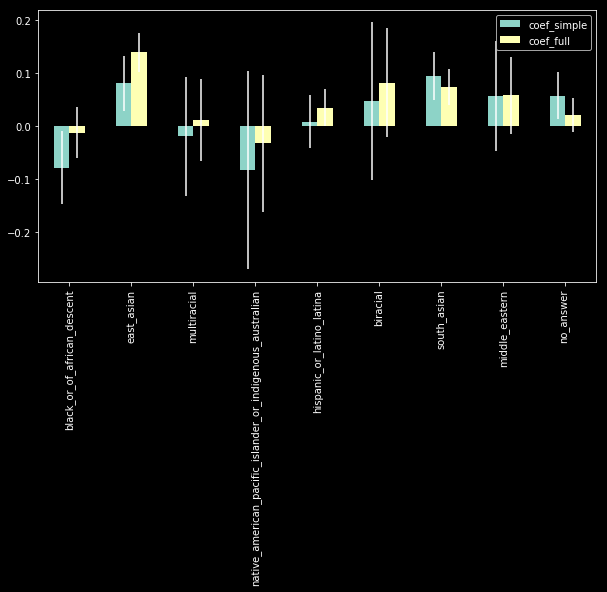

In [128]:
test[["coef_simple", "coef_full"]].plot(kind="bar", figsize=(10,5), yerr=test[["conf_95_simple", "conf_95_full"]].rename(columns={"conf_95_simple": "coef_simple", "conf_95_full": "coef_full"}))

In [27]:
est.bse

const                                                                                   0.035210
Hobbyist_no                                                                             0.008053
Employment_employed_part_time                                                           0.031418
Employment_independent_contractor_freelancer_or_self_employed                           0.051108
Employment_no_answer                                                                    0.107838
Student_yes_part_time                                                                   0.017836
Student_yes_full_time                                                                   0.018779
Student_no_answer                                                                       0.084109
EdLevel_primary_elementary_school                                                       0.060350
EdLevel_professional_degree_jd_md_etc_                                                  0.048727
EdLevel_masters_degree_ma_ms_m